In [116]:
import torch
import numpy as np
import torch.nn as nn
import sys
import os
project_root = os.path.abspath("..")  # Adjust if needed
import pytorch_lightning as pl
# Add the project root to sys.path
if project_root not in sys.path:
    sys.path.append(project_root)

# from src.models.pointNetVae import PointNetVAE

from src.models.PointNetVae_chamfer_split import PointNetVAE
from src.utils.data_utils import *
from src.dataset_classes.pointDataset import *
from proteinshake.datasets import ProteinFamilyDataset
from proteinshake.tasks import LigandAffinityTask
import random
from torch.utils.data import DataLoader, Dataset, Subset, TensorDataset
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# dataset = ProteinFamilyDataset(root='../data').to_point().torch()
# import random

# idx_list = range(len(dataset))
# subset_size = int(len(dataset)//10)
# val_idx = random.sample(idx_list, subset_size)  # Get random subset
# train_idx = list(set(idx_list) - set(val_idx))

# s = 500
# train_subset = PointDataset(Subset(dataset, train_idx), s, return_proteins=True)
# val_subset = PointDataset(Subset(dataset, val_idx), s, return_proteins=True)

# norm_train = '../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'
# norm_val = '../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt'

# non_norm_train = '../data/processed/point/Pfam_Point_Processed_non_norm/Pfam_data_train_non_norm.pt'
# non_norm_val = '../data/processed/point/Pfam_Point_Processed_non_norm/Pfam_data_val_non_norm.pt'

norm_train = 'Pfam_data_train_norm.pt'
norm_val = 'Pfam_data_val_norm.pt'

from torch.utils.data import TensorDataset
train_subset = TensorDataset(torch.load(norm_train))
val_subset = TensorDataset(torch.load(norm_val))

train_dataloader = DataLoader(train_subset, batch_size = 128)
val_dataloader = DataLoader(val_subset, batch_size = 128)

In [133]:
import json

train_tensor = []
val_tensor = []

point_pfam_train_dict = dict()
point_pfam_val_dict = dict()

train_max = find_max_radius(train_subset)
val_max = find_max_radius(val_subset)

for tens in train_subset:
    train_tensor.append(tens)

for tens in val_subset:
    val_tensor.append(tens)


for idx, protein in enumerate(train_subset.org_protein_data):
    point_pfam_train_dict[idx] = protein[1]['protein']['Pfam']

for idx, protein in enumerate(val_subset.org_protein_data):
    point_pfam_val_dict[idx] = protein[1]['protein']['Pfam']

with open('point_train_labels_non_norm.json', 'w') as f:
    json.dump(point_pfam_train_dict, f, indent=4)


with open('point_val_labels_non_norm.json', 'w') as f:
    json.dump(point_pfam_val_dict, f, indent=4)
    
train_tensor = torch.stack(train_tensor)
val_tensor = torch.stack(val_tensor)

# distances_train = torch.norm(input=train_tensor[:,:,:3], p=2, dim=2)
# distances_val = torch.norm(input=val_tensor[:,:,:3], p=2, dim=2)

# max_distances_train = torch.max(distances_train, dim=1, keepdim=True)[0]
# max_distances_val =  torch.max(distances_val, dim=1, keepdim=True)[0]

train_tensor[:,:,:3] = train_tensor[:,:,:3] / train_max #max_distances_train.unsqueeze(1) 
val_tensor[:,:,:3] = val_tensor[:,:,:3] / val_max #max_distances_val.unsqueeze(1) 

torch.save(train_tensor, 'Pfam_data_train_norm.pt')
torch.save(val_tensor, 'Pfam_data_val_norm.pt')






100%|██████████| 25866/25866 [00:00<00:00, 45652.15it/s]

100%|██████████| 2885/2885 [00:00<00:00, 47995.27it/s]


In [125]:
# dummy_in = torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt')[:128,:,:]
# dummy_in.shape

In [126]:
latent_dim = 64
epochs = 30
lr = 0.001
batch_size = 128
epochs = 100

if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [137]:
import torch.optim.adam
model = PointNetVAE(latent_dim,torch.optim.Adam,{'lr':0.001}, beta = 0.001, beta_increment = 0, hidden_dim = 1024, global_feature_size = 512, conv_hidden_dim = 4)
model


PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (conv1): Conv1d(3, 4, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (point_representation): Linear(in_features=8000, out_features=512, bias=True)
  (point_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (fc_point_dec): Linear(in_features=1024, out_features=1500, bias=True)
  (seq_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (sequence_decoder): Linear(in_features=1024, out_features=10500, bias=True)
)

In [138]:
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
optimizer = torch.optim.Adam
optimizer_param = {'lr':0.001}
trainer = pl.Trainer(max_epochs=epochs,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [139]:
trainer.fit(model, train_dataloader, val_dataloader)

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(

   | Name                 | Type        | Params | Mode 
--------------------------------------------------------------
0  | fc1_enc              | Linear      | 5.4 M  | train
1  | bn_label             | BatchNorm1d | 1.0 K  | train
2  | fc1_enc_mu           | Linear      | 65.6 K | train
3  | fc1_enc_logvar       | Linear      | 65.6 K | train
4  | conv1                | Conv1d      | 16     | train
5  | conv2                | Conv1d      | 40     | train
6  | conv3                | Conv1d      | 144    | train
7  | tanh                 | Tanh        | 0      | train
8  | soft                 | Softmax     | 0      | train
9  | point_representation | Linear      | 4.1 M  | train
10 | point_dec_1          | Linear      | 66.6 K | train
11 | fc_point_dec         

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/opt/anaconda3/envs/ProteinManifoldLearning/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# LOAD AND VISUALISE MODEL

In [140]:
# Load the trained model from checkpoint
# checkpoint_path = "../trained_models/Pfam/point_vae/00-26-03_SWEEP_NON_CHAMFER_Pfam_PointVAE_study_BS128_MS500_trials10/1_LD128_GF512_BetaInc0_Beta0.05.ckpt"
# model = PointNetVAE.load_from_checkpoint(checkpoint_path)

# Put model in evaluation mode
model.eval()

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (conv1): Conv1d(3, 4, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (point_representation): Linear(in_features=8000, out_features=512, bias=True)
  (point_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (fc_point_dec): Linear(in_features=1024, out_features=1500, bias=True)
  (seq_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (sequence_decoder): Linear(in_features=1024, out_features=10500, bias=True)
)

In [15]:
import json
dataset =  TensorDataset(torch.concatenate([torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_train.pt'), 
                   torch.load('../data/processed/point/Pfam_Point_Processed_tensors/Pfam_data_val.pt')], dim = 0))
                   
point_dataloader = DataLoader(dataset,256, shuffle=False)

with open('../data/processed/point/Pfam_Point_Processed_tensors/point_train_labels.json') as f:
    labels_train = json.load(f)
with open('../data/processed/point/Pfam_Point_Processed_tensors/point_val_labels.json') as f:
    labels_val = json.load(f)
labels = {**labels_train, **labels_val}

In [141]:
lengths = [torch.sum(k[0][:,3:].sum(), dim = -1) for k in dataset if k[0][:,3:].sum() < 500]
# families = [labels[key][0] for key in labels.keys()]

In [142]:
if torch.cuda.is_available():
    torch.cuda.current_device()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

PointNetVAE(
  (fc1_enc): Linear(in_features=10500, out_features=512, bias=True)
  (bn_label): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1_enc_mu): Linear(in_features=1024, out_features=64, bias=True)
  (fc1_enc_logvar): Linear(in_features=1024, out_features=64, bias=True)
  (conv1): Conv1d(3, 4, kernel_size=(1,), stride=(1,))
  (conv2): Conv1d(4, 8, kernel_size=(1,), stride=(1,))
  (conv3): Conv1d(8, 16, kernel_size=(1,), stride=(1,))
  (tanh): Tanh()
  (soft): Softmax(dim=-1)
  (point_representation): Linear(in_features=8000, out_features=512, bias=True)
  (point_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (fc_point_dec): Linear(in_features=1024, out_features=1500, bias=True)
  (seq_dec_1): Linear(in_features=64, out_features=1024, bias=True)
  (sequence_decoder): Linear(in_features=1024, out_features=10500, bias=True)
)

In [144]:
# labels = []
latent_coord = []
model.eval()
total_samples = []
model.eval()
from tqdm import tqdm
for batch in tqdm(train_dataloader):
    # labels.append(batch[1].to('cpu').numpy())
    rep_z, x_mu, x_logvar, x_rec, logit = model(batch[0].to(device))
    total_samples.append(x_mu.shape[0])
    latent_coord.append(x_mu.detach().cpu().numpy())
# labels = np.concatenate(labels)``
latent_coord = np.concatenate(latent_coord, axis = 0)




















































100%|██████████| 203/203 [00:05<00:00, 37.25it/s]


In [145]:
U, S, V = torch.pca_lowrank(torch.tensor(latent_coord), q=None, center=True, niter=2)
projected_data = torch.matmul(torch.tensor(latent_coord), V[:, :2]) 
# projected_data = np.concatenate(latent_coord)

Text(0.5, 1.0, 'Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')

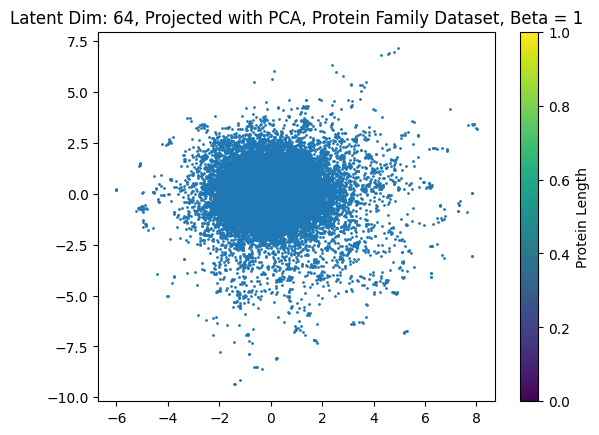

In [146]:
import matplotlib.pyplot as plt
plt.scatter(projected_data[:, 0], projected_data[:, 1], s = 1) #c=lengths[:projected_data.shape[0]], cmap='viridis')
plt.colorbar(label = 'Protein Length')
plt.title('Latent Dim: 64, Projected with PCA, Protein Family Dataset, Beta = 1')
# plt.savefig("exp_1_latent_Pfam.png")